# Potwierdzam samodzielność powyższej pracy oraz niekorzystanie przeze mnie z niedozwolonych źródeł. Olaf Werner¶

In [271]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from copy import deepcopy

In [272]:
np.random.seed(123)

## maksymalizujemy fit więc mnożymy przez -1

In [273]:
def cross_entropy(targets,predictions,  epsilon=1e-12):
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    ce = abs(np.sum(targets*np.log(predictions)))
    return -ce

In [274]:
def MSE(Y,Y_hat):
    return -np.sum((Y-Y_hat)**2)

In [275]:
def sigmoid(x):
    return(1/(1 + np.exp(-x)))

# NeuroEvolution of Augmenting Topologies NEAT

In [276]:
class NEAT:
    
    class network:
        def __init__(self,gen_input_size,gen_output_size,var,activation_function):
            #node genes
            self.gen_node=np.ones((gen_input_size+gen_output_size,2)).astype(int)
            #first col neuron number
            self.gen_node[:,0]=np.arange(gen_input_size+gen_output_size).astype(int)
            #second column type of neuron -1 input,1 output, 0 hidden
            self.gen_node[:gen_input_size,1]=-1
            
            #height of node genes
            self.gen_height=np.ones((gen_input_size+gen_output_size,2))
            #first col neuron number
            self.gen_height[:,0]=np.arange(gen_input_size+gen_output_size)
            #second column height of neuron -1 input,1 output, between hidden
            self.gen_height[:gen_input_size,1]=-1
            
            #connection gen
            self.gen_con=np.ones((gen_input_size*gen_output_size,5))
            #first column innovation number, second  input, third  output, fourth weight, fifth activ
            k=0
            for i in range(gen_input_size):
                for j in range(gen_output_size):
                    self.gen_con[k,0]=k
                    self.gen_con[k,1]=i
                    self.gen_con[k,2]=gen_input_size+j
                    k+=1
            
            self.gen_input_size=gen_input_size
            self.gen_output_size=gen_output_size
            self.var=var
            #local base for tracking hom many times connection was used for adding nodes
            self.mini_gen_base={}
            self.activation_function=activation_function
        
        
        def mutate_weight(self):
            con_id_rel=np.random.randint(self.gen_con.shape[0])
            self.gen_con[con_id_rel,3]=self.gen_con[con_id_rel,3]+np.random.normal(0,self.var)
            
        def mutate_activation(self):
            con_id_rel=np.random.randint(self.gen_con.shape[0])
            if self.gen_con[con_id_rel,4]==1:
                self.gen_con[con_id_rel,4]=0
            else:
                self.gen_con[con_id_rel,4]=1
                
        
        def mutate_add_connection(self,con_base,last_con,times_try=10):
            #chose two neurons
            i=0
            while(i<times_try):
                node_id_rel1=np.random.randint(self.gen_node.shape[0])
                node_id_rel2=np.random.randint(self.gen_node.shape[0])
                #wrong height
                if self.gen_height[node_id_rel1,1]==self.gen_height[node_id_rel2,1]:
                    i+=1
                    continue
                #swap places
                if self.gen_height[node_id_rel1,1]>self.gen_height[node_id_rel2,1]:
                    temp=node_id_rel1
                    node_id_rel1=node_id_rel2
                    node_id_rel2=temp
                    
                con_to_add=con_base.get((self.gen_node[node_id_rel1,0],self.gen_node[node_id_rel2,0]))
                if con_to_add in self.gen_con[:,0]:
                    i+=1
                    continue
                    
                if con_to_add==None:
                    #add new connections
                    self.gen_con=np.append(self.gen_con,np.array([[last_con[0],self.gen_node[node_id_rel1,0],self.gen_node[node_id_rel2,0],1,1]]),axis=0)
                    con_base.update({(self.gen_node[node_id_rel1,0],self.gen_node[node_id_rel2,0]):last_con[0]})
                    last_con[0]=last_con[0]+1
                else:
                    self.gen_con=np.append(self.gen_con,np.array([[con_to_add,self.gen_node[node_id_rel1,0],self.gen_node[node_id_rel2,0],1,1]]),axis=0)
                
                break
        
        
        
        def mutate_add_neuron(self,gen_base,con_base,last_node,last_con):
            #relative id
            con_id_rel=np.random.randint(self.gen_con.shape[0])
            #global id
            con_id=self.gen_con[con_id_rel][0]
            con_id=int(con_id)
            node=gen_base.get(con_id)
            #deactivate
            self.gen_con[con_id_rel,4]=0
            if node==None:
                #add new connections
                self.gen_con=np.append(self.gen_con,np.array([[last_con[0],self.gen_con[con_id_rel,1],last_node[0],1,1]]),axis=0)
                self.gen_con=np.append(self.gen_con,np.array([[last_con[0]+1,last_node[0],self.gen_con[con_id_rel,2],self.gen_con[con_id_rel,3],1]]),axis=0)
                #update base
                self.mini_gen_base.update({con_id:1})
                gen_base.update({con_id:[last_node[0]]})
                con_base.update({(self.gen_con[con_id_rel,1],last_node[0]):last_con[0]})
                con_base.update({(last_node[0],self.gen_con[con_id_rel,2]):last_con[0]+1})
                self.gen_node=np.append(self.gen_node,np.array([[last_node[0],0]]),axis=0)
                #height
                w1=self.gen_height[self.gen_height[:,0]==self.gen_con[con_id_rel,1],1][0]
                w2=self.gen_height[self.gen_height[:,0]==self.gen_con[con_id_rel,2],1][0]
                self.gen_height=np.append(self.gen_height,np.array([[last_node[0],w1/2+w2/2]]),axis=0)
                last_con[0]=last_con[0]+2
                last_node[0]=last_node[0]+1
                
            else:
                #check how many times already
                times=self.mini_gen_base.get(con_id)
                if times==None:
                    times=0
                
                times+=1
                
                if times>len(node):
                    #add new connections
                    self.gen_con=np.append(self.gen_con,np.array([[last_con[0],self.gen_con[con_id_rel,1],last_node[0],1,1]]),axis=0)
                    self.gen_con=np.append(self.gen_con,np.array([[last_con[0]+1,last_node[0],self.gen_con[con_id_rel,2],self.gen_con[con_id_rel,3],1]]),axis=0)
                    #update base
                    self.mini_gen_base.update({con_id:times})
                    gen_base.update({con_id:node+[last_node[0]]})
                    con_base.update({(self.gen_con[con_id_rel,1],last_node[0]):last_con[0]})
                    con_base.update({(last_node[0],self.gen_con[con_id_rel,2]):last_con[0]+1})
                    self.gen_node=np.append(self.gen_node,np.array([[last_node[0],0]]),axis=0)
                    #height
                    w1=self.gen_height[self.gen_height[:,0]==self.gen_con[con_id_rel,1],1][0]
                    w2=self.gen_height[self.gen_height[:,0]==self.gen_con[con_id_rel,2],1][0]
                    self.gen_height=np.append(self.gen_height,np.array([[last_node[0],w1/2+w2/2]]),axis=0)
                    last_con[0]=last_con[0]+2
                    last_node[0]=last_node[0]+1
                else:
                    #add new connections based on bases
                    node=node[times-1]
                    self.gen_con=np.append(self.gen_con,np.array([[con_base.get((self.gen_con[con_id_rel,1],node)),self.gen_con[con_id_rel,1],node,1,1]]),axis=0)
                    self.gen_con=np.append(self.gen_con,np.array([[con_base.get((node,self.gen_con[con_id_rel,2])),node,self.gen_con[con_id_rel,2],self.gen_con[con_id_rel,3],1]]),axis=0)
                    #update base
                    self.mini_gen_base.update({con_id:times})
                    self.gen_node=np.append(self.gen_node,np.array([[node,0]]),axis=0)
                    #height
                    w1=self.gen_height[self.gen_height[:,0]==self.gen_con[con_id_rel,1],1][0]
                    w2=self.gen_height[self.gen_height[:,0]==self.gen_con[con_id_rel,2],1][0]
                    self.gen_height=np.append(self.gen_height,np.array([[node,w1/2+w2/2]]),axis=0)
                    
        def softmax(self,z):
            e = np.exp(np.clip(z,-300,300))
            return e / np.sum(e, axis=1,keepdims=True)
        
        def forward(self,data):
            memory={}
            def backward(node):
                #check if is input
                if node[1]==-1:
                    memory.update({node[0]:data[:,node[0]]})
                    return data[:,node[0]]
                
                suma=np.zeros(data.shape[0])
                connect=self.gen_con[(self.gen_con[:,2]==node[0]),]
                connect=connect[(connect[:,4]==1),]
                #all connected nodes
                for i in range(connect.shape[0]):
                    val=memory.get(connect[i,1])
                    if np.all(val==None):
                        val=backward(self.gen_node[self.gen_node[:,0]==connect[i,1],:].flatten())
                    
                    suma=suma+val*connect[i,3]
                    
                memory.update({node[0]:suma})
                if node[1]!=1:
                    return self.activation_function(suma)
                else:
                    return suma
            
            return self.softmax(np.array([backward(self.gen_node[i]) for i in range(self.gen_input_size,self.gen_input_size+self.gen_output_size)]).T)
                
        
            
            
    def __init__(self,population_size,gen_input_size,gen_output_size,fit_function,activation_function,var=0.25):
        self.fit_function=fit_function
        self.population=[self.network(gen_input_size,gen_output_size,var,activation_function) for x in range(population_size)]
        self.gen_input_size=gen_input_size
        self.gen_output_size=gen_output_size
        self.population_size=population_size
        self.var=var
        self.activation_function=activation_function
        self.gen_base={}
        self.con_base={}
        self.last_node=[gen_input_size+gen_output_size]
        self.last_con=[gen_input_size*gen_output_size]
        k=0
        for i in range(gen_input_size):
            for j in range(gen_output_size):
                self.con_base.update({(i,gen_input_size+j):k})
                k+=1
        
    
    def normalize(self,z):
        e=z-np.min(z)
        return e/np.sum(e)
    
    
    def softmax(self,z):
        e = np.exp(z)
        return e / np.sum(e, axis=1,keepdims=True)
    
    
    def similarity(self,net1,net2):
        df=pd.merge(pd.DataFrame(net1.gen_con),pd.DataFrame(net2.gen_con),on=0,how="inner")
        return abs(df["3_x"]-df["3_y"]).mean()*0.4+(1-2*df.shape[0]/(net1.gen_con.shape[0]+net2.gen_con.shape[0]))
        
    
    def cross(self,net1,net2):
        if self.similarity(net1,net2)<0.45:
            child=self.network(self.gen_input_size,self.gen_output_size,self.var,self.activation_function)
            #join based on con id
            df=pd.merge(pd.DataFrame(net1.gen_con),pd.DataFrame(net2.gen_con),on=0,how="outer")
            t1=df.loc[df["1_y"].isna(),[0,"1_x","2_x","3_x","4_x"]].to_numpy()
            t2=df.loc[df["1_x"].isna(),[0,"1_y","2_y","3_y","4_y"]].to_numpy()
            #random
            t3=df.loc[df["1_x"].notna()].loc[df["1_y"].notna()].to_numpy()
            ra=np.random.choice([True,False],t3.shape[0],p=[0.5,0.5])
            t3[ra==True,3]=t3[ra==True,7]
            t3=t3[:,:5]
            con=np.append(t1,t2,axis=0)
            con=np.append(t3,con,axis=0).copy()
            nod=np.unique(np.append(net1.gen_node,net2.gen_node,axis=0),axis=0).copy()
            hei=np.unique(np.append(net1.gen_height,net2.gen_height,axis=0),axis=0).copy()
            #update 
            child.gen_con=con
            child.gen_height=hei
            child.gen_node=nod
            #update keys
            child.mini_gen_base.update(net1.mini_gen_base.copy())
            for k in net2.mini_gen_base.keys():
                if child.mini_gen_base.get(k)==None:
                    child.mini_gen_base.update({k:net2.mini_gen_base.get(k)})
                elif child.mini_gen_base.get(k)<net2.mini_gen_base.get(k):
                    child.mini_gen_base.update({k:net2.mini_gen_base.get(k)})
            return child
        else:
            return deepcopy(net1)
    
    def fitness(self,data,values):
        fit=np.zeros(self.population_size)
        for i in range(self.population_size):
            p=self.population[i]
            fit[i]=self.fit_function(values,p.forward(data))
            
        return fit
    
    def train(self,generations,data,values):
        fit=np.zeros(self.population_size)
        species=np.zeros(self.population_size)
        for g in range(generations):
            print(g)
            new_population=[0 for x in range(self.population_size)]
            for i in range(self.population_size):
                p=self.population[i]
                if np.random.random()<0.03:
                    p.mutate_add_neuron(self.gen_base,self.con_base,self.last_node,self.last_con)
                if np.random.random()<0.05:
                    p.mutate_add_connection(self.con_base,self.last_con,times_try=10)
                if np.random.random()<0.8:
                    p.mutate_weight()
                    p.mutate_activation()
                if np.random.random()<0.8:
                    p.mutate_activation()
                
                fit[i]=self.fit_function(values,p.forward(data))
            
            #for i in range(self.population_size):
                 
            
            prob=self.normalize(fit)
            parents=np.random.choice(np.arange(self.population_size),self.population_size*2,p=prob)
            for c in range(self.population_size):
                if fit[parents[2*c]]>=fit[parents[2*c+1]]:
                    new_population[c] = self.cross(self.population[parents[2*c]],self.population[parents[2*c+1]])
                else:
                    new_population[c] = self.cross(self.population[parents[2*c+1]],self.population[parents[2*c]])
                
            self.population=new_population
            
                
            

# Test na Rings-3

### Załaduj data set

In [277]:
test = np.loadtxt("rings3-regular-training.csv", delimiter=',', skiprows=1, usecols=range(0,3))
np.random.shuffle(test)
X=test[:,0:2]
Y=test[:,2:3]
Y=Y==np.unique(Y)
Y=np.array(Y,dtype=int)
train_input_layer=(X-np.mean(X,axis=0))/np.std(X,axis=0)
train_output_layer=Y

In [278]:
test = np.loadtxt("rings3-regular-test.csv", delimiter=',', skiprows=1, usecols=range(0,3))
X1=test[:,0:2]
Y1=test[:,2:3]
Y1=Y1==np.unique(Y1)
Y1=np.array(Y1,dtype=int)
test_input_layer=(X1-np.mean(X,axis=0))/np.std(X,axis=0)
test_output_layer=Y1

## Inicjalizuj NEAT

In [279]:
test=NEAT(population_size=150,gen_input_size=2,gen_output_size=3,fit_function=cross_entropy,activation_function=sigmoid,var=0.5)

In [280]:
test.train(100,train_input_layer,train_output_layer)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [281]:
best_net=test.population[np.argmax(test.fitness(train_input_layer,train_output_layer))]

# Rezultaty

[Text(0.5, 1.0, 'Test data')]

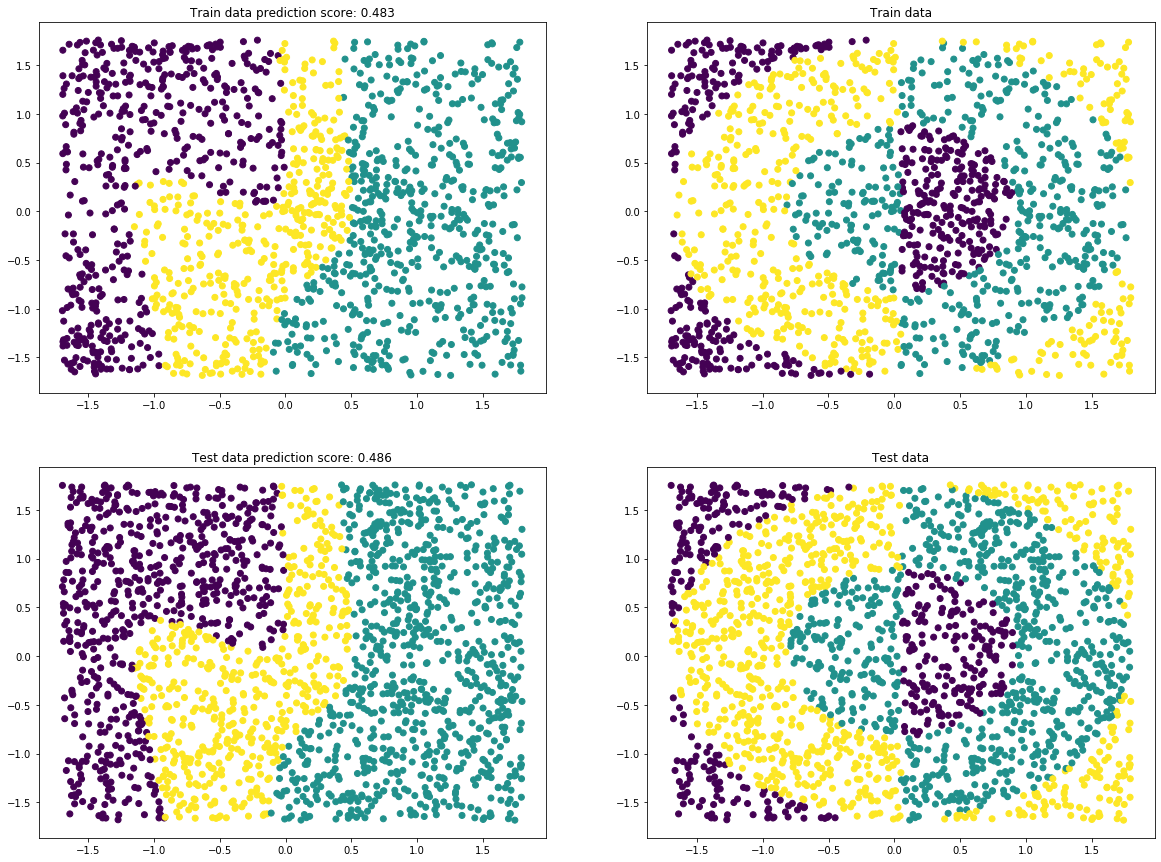

In [282]:
output_layer=best_net.forward(train_input_layer)
fig=plt.figure(figsize=(20,15))
ax=fig.add_subplot(221)
ax.scatter(train_input_layer[:,0],train_input_layer[:,1],c=np.argmax(output_layer,axis=1))
ax.set(title='Train data prediction score: '+str(round(np.mean(np.argmax(train_output_layer,axis=1)==np.argmax(output_layer,axis=1)),3)))

ax1=fig.add_subplot(222)
ax1.scatter(train_input_layer[:,0],train_input_layer[:,1],c=np.argmax(train_output_layer,axis=1))
ax1.set(title="Train data")


output_layer=best_net.forward(test_input_layer)

ax2=fig.add_subplot(223)
ax2.scatter(test_input_layer[:,0],test_input_layer[:,1],c=np.argmax(output_layer,axis=1))
ax2.set(title='Test data prediction score: '+str(round(np.mean(np.argmax(test_output_layer,axis=1)==np.argmax(output_layer,axis=1)),3)))

ax3=fig.add_subplot(224)
ax3.scatter(test_input_layer[:,0],test_input_layer[:,1],c=np.argmax(test_output_layer,axis=1))
ax3.set(title="Test data")

## Podsumowanie

Otrzymaliśmy nie najlepsze rezultaty, najwyraźniej specjacja jest kluczowym elementem algorytmu NEAT. W przyszłości zostanie zaimplementowany. Oprócz specjacji to wszystkie wymagane elementy zostały zaimplementowane.

## parametry najlepszej sieci (aktywne połązenia)

In [284]:
best_net.gen_con[best_net.gen_con[:,4]==1]

array([[ 0.00000000e+00,  0.00000000e+00,  2.00000000e+00,
        -6.13920407e-01,  1.00000000e+00],
       [ 1.00000000e+00,  0.00000000e+00,  3.00000000e+00,
         1.25307683e+00,  1.00000000e+00],
       [ 1.70000000e+01,  0.00000000e+00,  1.00000000e+01,
         1.51782838e+00,  1.00000000e+00],
       [ 8.00000000e+00,  1.00000000e+00,  6.00000000e+00,
         1.51566812e+00,  1.00000000e+00],
       [ 1.10000000e+01,  7.00000000e+00,  2.00000000e+00,
         9.91340341e-01,  1.00000000e+00],
       [ 1.90000000e+01,  1.00000000e+01,  3.00000000e+00,
        -1.60750080e+00,  1.00000000e+00],
       [ 4.70000000e+01,  1.80000000e+01,  6.00000000e+00,
         1.90441942e+00,  1.00000000e+00],
       [ 2.90000000e+01,  1.20000000e+01,  4.00000000e+00,
         5.03903576e-02,  1.00000000e+00],
       [ 5.30000000e+01,  2.00000000e+01,  4.00000000e+00,
         1.41302863e+00,  1.00000000e+00],
       [ 2.60000000e+01,  0.00000000e+00,  8.00000000e+00,
         6.79572906e-01

pierwsza kolumna to id połączenia, druga to neuron wejściowy, trzecia neuron wyjściowy, czwarta to waga, piata to aktywność połączenia.

# parametry najlepszej sieci (neurony)

pierwsza kolumna to id neuronu, druga to rodzaj neuronu(-1 wejścia, 0 ukryty, 1 wyjścia)

In [285]:
best_net.gen_node

array([[  0,  -1],
       [  1,  -1],
       [  2,   1],
       [  3,   1],
       [  4,   1],
       [  6,   0],
       [  7,   0],
       [  8,   0],
       [ 10,   0],
       [ 11,   0],
       [ 12,   0],
       [ 14,   0],
       [ 16,   0],
       [ 18,   0],
       [ 19,   0],
       [ 20,   0],
       [ 21,   0],
       [ 33,   0],
       [ 35,   0],
       [ 44,   0],
       [ 55,   0],
       [ 63,   0],
       [ 68,   0],
       [ 74,   0],
       [ 82,   0],
       [ 84,   0],
       [ 89,   0],
       [ 90,   0],
       [ 96,   0],
       [100,   0],
       [106,   0],
       [110,   0],
       [118,   0],
       [119,   0],
       [122,   0],
       [129,   0],
       [135,   0],
       [142,   0]])